# Multi-Period Binomial Asset Pricing Model

Consider a multiperiod binomial asset model for an asset S with N periods. Under this particular model, we have the following assumptions:
- the initial price of the asset is $S_0 = 1$
- under the risk-neutral measure, the asset price at period $j$ is $S_j = (1+v)S_{j-1}$ with probability $1/2$, with $0 < v < 1$; and 
- the interest rate associated with borrowing/lending currency for a single time period is 0.  

## Import Libraries

In [1]:
# Import necessary libraries 

import numpy as np 
import matplotlib.pyplot as plt 

#### Implement a function which, given v, and the strike K of a European call option on the asset S, expiring after N periods, returns its value V. 

In [2]:
def european_call_option_value(v, K, S, N): 
    u = 1 + v
    d = 1 - v
    p = 0.5  # Probability of up move

    # Calculate risk-neutral probability (not necessary since p is given and r = 0)
    q = p  # Since r = 0, we don't need to adjust for risk-neutral probabilities

    # Initialize an array to hold the stock prices at maturity
    stock_prices_at_maturity = np.array([S * (u ** (N - i)) * (d ** i) for i in range(N+1)])

    # Calculate the option payoffs at maturity
    option_payoffs = np.maximum(stock_prices_at_maturity - K, 0)
    
    # Calculate the expected payoff
    expected_payoff = sum([option_payoffs[i] * binom(N, i) * (q ** (N - i)) * ((1 - q) ** i) for i in range(N+1)])

    # Since r=0, we don't need to discount the expected payoff
    option_price_today = expected_payoff

    return option_price_today

# Helper function to calculate binomial coefficient
def binom(n, k):
    return np.math.factorial(n) // (np.math.factorial(k) * np.math.factorial(n - k))

# Example usage:
v = 0.1  # Volatility factor
K = 1.02  # Strike price
S0 = 1    # Initial stock price
N = 5     # Number of periods
option_value = european_call_option_value(v, K, S0, N)
print(f"The value of the European call option is: {option_value}")


The value of the European call option is: 0.0831268750000002


## Question 2

In [5]:
epochs = 1000
eta = 0.01

# Back propagation

def Q2(K, V, S, N):
    
    # Initialise some growth rate between 0 and 1
    v_hat = 0.9
    
    # Storage for the losses
    losses = []
    
    for it in range(epochs):

        # Recall growth factors for up-state and down-state
        u = 1 + v_hat
        d = 1 - v_hat

        # Calculate risk-neutral probabilities 
        q = ( (1 + r) - d ) / ( u - d )

        # Calculate discount 
        discount = (1/(1+r)**N)

        # Possible paths taken to maturity  
        downmoves = np.arange(N,-1,-1)
        upmoves = np.arange(0,N+1,1)

        # Initialise stock prices at maturity for a recombining tree in a dynamically complete market 
        Stock = S * d**downmoves * u**upmoves

        # European Call Option can only be exercised at maturity, hence I am unconcerned by events t : [1,...,N-1] 
        EuroCall_payoffs = np.maximum(0, Stock - K)

        # Calculate the discounted risk neutral expectation of call price, today 
        prob = q**downmoves * (1-q)**upmoves
        Expectation = EuroCall_payoffs * prob
        EuroCall_Price0 = discount * Expectation.sum()
        
        # Compute square losses, then store  
        loss = (EuroCall_Price0 - V)**2
        losses.append(loss)
        
        # Trigger to stop the loop if convergence occurs early
        if loss == 0:
            return v_hat
        
        # Individual derivatives
        payoff_prime = S * (upmoves * d**downmoves * u**(upmoves - 1) - downmoves * d**(downmoves - 1) * u**upmoves)
        prob_prime = (r / 2 * v_hat**2) * (upmoves * q**downmoves * (1 - q)**(upmoves-1) - downmoves * q**(downmoves-1) * (1 - q)**upmoves)
        
        # Gradient terms, resulting from product rule 
        grad1 = payoff_prime * prob
        grad2 = EuroCall_payoffs * prob_prime
        
        # Derivative of the loss function with respect to v, i.e. complete gradient term
        gradient = (discount * 2 * (EuroCall_Price0 - V) * (grad1 + grad2)).sum()
        
        # Update v_hat 
        v_hat -= eta * gradient
        
    return v_hat, losses, payoff_prime, EuroCall_Price0

optimal_v = Q2(K = 1.02, V = 0.25265625, S = S0, N = 5)
print(optimal_v[0]) 


0.500000734879096


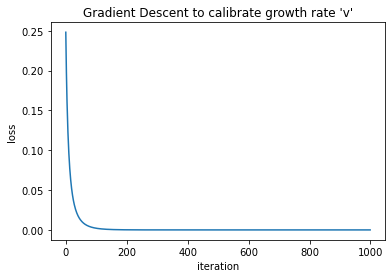

In [6]:
# Plotting the losses of the gradient descent model used to calibrate growth rate, v
plt.plot(optimal_v[1])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Gradient Descent to calibrate growth rate 'v'")

plt.show()

## Question 3

In [13]:
# Define function to calculate value of American call option
def Q3(v, r, K, S, N): 
   
    # Recall growth factors
    u = 1 + v 
    d = 1 - v
    
    # Calculate risk-neutral probabilities 
    q = ( (1 + r) - d ) / ( u - d )

    # Calculate discount 
    discount = 1 #due to risk free rate being 0 
    
    # Possible paths to maturity  
    downmoves = np.arange(N,-1,-1)
    upmoves = np.arange(0,N+1,1)
    
    # Stock Prices at maturity 
    Stock = S * d**downmoves * u**upmoves

    # American Call Payoff at Maturity 
    AmerCall = np.maximum(0, Stock - K)
    
    # Can be exercised before maturity -> Back propagate through the tree
    for steps in np.arange(N-1,-1,-1): #from second to last column to second column
        Stocks = S * d**(np.arange(steps,-1,-1)) * u**(np.arange(0,steps+1,1)) #each time we step through time of tree, calculate full array
        AmerCall[:steps+1] = discount * ( q*AmerCall[1:steps+2] + (1-q)*AmerCall[:steps+1] ) #to update possible downpaths and up paths for each split 
        AmerCall = AmerCall[:-1] #knock off the last value when stepping back through the tree, so S and C have same size
        
        AmerCall = np.maximum(AmerCall, S - K) # Keep either continuation value, or exercise option at current node
        
        print(Stocks, AmerCall)
    
    return (AmerCall[0])

AmericanCall_price = Q3(v = v[5], r = r, K = 1.02, S = S0, N = 5)

print(AmericanCall_price)
    

[0.0625 0.1875 0.5625 1.6875 5.0625] [0.       0.       0.       0.755625 4.0425  ]
[0.125 0.375 1.125 3.375] [0.        0.        0.3778125 2.3990625]
[0.25 0.75 2.25] [0.         0.18890625 1.3884375 ]
[0.5 1.5] [0.09445312 0.78867188]
[1.] [0.4415625]
0.4415625000000001


## Question 4

* I expect largest stock price at each period j, will occur in state where price only goes up for N periods
* Therefore, where growth rate, v, is taken as constant then expectation (mean) of largest stock value should occur at the last node

In [7]:
N = 5
S0 = 1

#---------------------------#
#-----------For Fun---------#
#---------------------------#

# Define function for largest stock value
def max_stocks(v):
    u = 1 + v 
    Stock = S0 * u**np.arange(1, N+1, 1) 
    
#---------------------------#
#------------Q4-------------#
#---------------------------#

# Define function for expectation of largest Stock prices at maturity for European Option 
def expectation_Sj(v):
    
    # Recall growth factors for up-state and down-state
    u = 1 + v
    d = 1 - v
    
    # Expectation 
    Max_expectation = []

    # Initialise stock prices at maturity for a recombining tree in a dynamically complete market 
    for steps in np.arange(N,-1,-1): #from second to last column to second column
        Stocks = S0 * d**(np.arange(steps,-1,-1)) * u**(np.arange(0,steps+1,1)) 
        Expectation = np.mean(Stocks)
        Max_expectation.append(Expectation)
    
    return (max(Max_expectation), Max_expectation)

Expectation_max_S_j = expectation_Sj(v = v[9])

print (Expectation_max_S_j)

# Account for all possible paths 
# Then calculate the maximum across all paths in time 
# Then take the expectation 
# Look back option -- similar concept 

(4.356099999999999, [4.356099999999999, 2.7512199999999996, 1.8099999999999998, 1.2699999999999998, 1.0, 1.0])
